In [2052]:
import torch
from torchvision import transforms, datasets
import torch.utils.data as data
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2053]:
df = pd.read_csv("train_data.csv")

# Data processing
- y - class from 0 to 3 according to the following:
    - 0 to 100k - class 0
    - 100k to 350k - class 1
    - 350k and above - class 2
        

Features:
- YearBuilt - numeric
- Size(sqf) - numeric
- Floor - numeric
- HallwayType - one hot encoding
- HeatingType - binary encoding
- AptManageType - binary encoding
- N_Parkinglot(Ground) - numeric
- N_Parkinglot(Basement) - numeric
- TimeToBusStop - one hot encoding
- TimeToSubway - one hot encoding
- N_manager - numeric
- N_elevators - numeric
- SubwayStation - one hot encoding
- N_FacilitiesInApt - numeric
- N_FacilitiesNearBy(Total) - numeric
- N_SchoolNearBy(Total) - numeric

Train data: 4124
Train data per class: 0 - 562, 1 - 2992, 2 - 570


In [2054]:
df

,SalePrice,YearBuilt,Size(sqf),Floor,HallwayType,HeatingType,AptManageType,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,SubwayStation,N_FacilitiesInApt,N_FacilitiesNearBy(Total),N_SchoolNearBy(Total)
0,141592,2006,814,3,terraced,individual_heating,management_in_trust,111.0,184.0,5min~10min,10min~15min,3.0,0.0,Kyungbuk_uni_hospital,5,6.0,9.0
1,51327,1985,587,8,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
2,48672,1985,587,6,corridor,individual_heating,self_management,80.0,76.0,0~5min,5min~10min,2.0,2.0,Daegu,3,12.0,4.0
3,380530,2006,2056,8,terraced,individual_heating,management_in_trust,249.0,536.0,0~5min,0-5min,5.0,11.0,Sin-nam,5,3.0,7.0
4,78318,1992,644,2,mixed,individual_heating,self_management,142.0,79.0,5min~10min,15min~20min,4.0,8.0,Myung-duk,3,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,570796,2007,1928,24,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4120,307079,2015,644,22,terraced,individual_heating,management_in_trust,102.0,400.0,0~5min,5min~10min,5.0,10.0,Daegu,7,7.0,11.0
4121,357522,2007,868,20,terraced,individual_heating,management_in_trust,0.0,1270.0,0~5min,0-5min,14.0,16.0,Kyungbuk_uni_hospital,10,9.0,10.0
4122,312389,1978,1327,1,corridor,individual_heating,self_management,87.0,0.0,0~5min,0-5min,1.0,4.0,Kyungbuk_uni_hospital,3,7.0,11.0


In [2055]:
def preprocess_data(df: pd.DataFrame) -> pd.DataFrame:
    # Add classes
    df['class'] = pd.cut(df['SalePrice'], bins=[-float('inf'), 100000, 350000, float('inf')], labels=[0, 1, 2])
    df = df.drop(columns=["SalePrice"])

    # Encode TimeToSubway and TimeToBus
    df['TimeToBusStop'] = df['TimeToBusStop'].replace({
        "0~5min": 2,
        "5min~10min": 1,
        "10min~15min": 0
    })

    df['TimeToSubway'] = df['TimeToSubway'].replace({
        "0-5min": 4,
        "5min~10min": 3,
        "10min~15min": 2,
        "15min~20min": 1,
        "no_bus_stop_nearby": 0

    })
    
    # One hot encoding
    for_one_hot_encoding = ['HallwayType', 'SubwayStation']
    drop_first = True
    
    df = pd.get_dummies(df, columns=for_one_hot_encoding, drop_first=drop_first)
    
    # Binary encoding
    for_binary = ['HeatingType', 'AptManageType']
    df = pd.get_dummies(df, columns=for_binary, drop_first=True)
    
    # Scale numeric to range 0 to 1
    to_be_scaled = ['TimeToBusStop', 'TimeToSubway', 'YearBuilt', 'Size(sqf)', 'Floor', 'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager', 'N_elevators', 'N_FacilitiesInApt', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
    for column in to_be_scaled:
        df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())
    
    return df

In [2056]:
df = preprocess_data(df)
df

/tmp/ipykernel_10747/945653226.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToBusStop'] = df['TimeToBusStop'].replace({
/tmp/ipykernel_10747/945653226.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['TimeToSubway'] = df['TimeToSubway'].replace({


,YearBuilt,Size(sqf),Floor,N_Parkinglot(Ground),N_Parkinglot(Basement),TimeToBusStop,TimeToSubway,N_manager,N_elevators,N_FacilitiesInApt,...,HallwayType_terraced,SubwayStation_Banwoldang,SubwayStation_Chil-sung-market,SubwayStation_Daegu,SubwayStation_Kyungbuk_uni_hospital,SubwayStation_Myung-duk,SubwayStation_Sin-nam,SubwayStation_no_subway_nearby,HeatingType_individual_heating,AptManageType_self_management
0,0.756757,0.308356,0.047619,0.155680,0.139288,0.5,0.50,0.153846,0.000000,0.444444,...,True,False,False,False,True,False,False,False,True,False
1,0.189189,0.205268,0.166667,0.112202,0.057532,1.0,0.75,0.076923,0.074074,0.222222,...,False,False,False,True,False,False,False,False,True,True
2,0.189189,0.205268,0.119048,0.112202,0.057532,1.0,0.75,0.076923,0.074074,0.222222,...,False,False,False,True,False,False,False,False,True,True
3,0.756757,0.872389,0.166667,0.349229,0.405753,1.0,1.00,0.307692,0.407407,0.444444,...,True,False,False,False,False,False,True,False,True,False
4,0.378378,0.231153,0.023810,0.199158,0.059803,0.5,0.25,0.230769,0.296296,0.222222,...,False,False,False,False,False,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4119,0.783784,0.814260,0.547619,0.000000,0.961393,1.0,1.00,1.000000,0.592593,1.000000,...,True,False,False,False,True,False,False,False,True,False
4120,1.000000,0.231153,0.500000,0.143058,0.302801,1.0,0.75,0.307692,0.370370,0.666667,...,True,False,False,True,False,False,False,False,True,False
4121,0.783784,0.332879,0.452381,0.000000,0.961393,1.0,1.00,1.000000,0.592593,1.000000,...,True,False,False,False,True,False,False,False,True,False
4122,0.000000,0.541326,0.000000,0.122020,0.000000,1.0,1.00,0.000000,0.148148,0.222222,...,False,False,False,False,True,False,False,False,True,True


In [2057]:
df.shape

(4124, 24)

In [2058]:
class_counts = df['class'].to_numpy()
unique, counts = np.unique(class_counts, return_counts=True)
print(counts)
weights = [1/x for x in counts]

[ 562 2992  570]


In [2059]:
train_dataset_raw = df.sample(frac=0.8, random_state=200)
df = df.drop(train_dataset_raw.index)
val_dataset_raw = train_dataset_raw.sample(frac=0.125, random_state=200) # 10% of original dataset
train_dataset_raw = train_dataset_raw.drop(val_dataset_raw.index)

test_dataset_raw = df
print("Dataset sizes")
print(f"Train: {len(train_dataset_raw)} samples")
print(f"Val:   {len(val_dataset_raw)} samples")
print(f"Test:  {len(test_dataset_raw)} samples")

Dataset sizes
Train: 2887 samples
Val:   412 samples
Test:  825 samples


In [2060]:
train_labels = train_dataset_raw['class'].to_numpy().astype(np.int64)
train_data = train_dataset_raw.drop(columns=['class']).to_numpy().astype(np.float32)

val_labels = val_dataset_raw['class'].to_numpy().astype(np.int64)
val_data = val_dataset_raw.drop(columns=['class']).to_numpy().astype(np.float32)

test_labels = test_dataset_raw['class'].to_numpy().astype(np.int64)
test_data = test_dataset_raw.drop(columns=['class']).to_numpy().astype(np.float32)

In [2061]:
train_dataset = data.TensorDataset(torch.from_numpy(train_data), torch.from_numpy(train_labels))
val_dataset = data.TensorDataset(torch.from_numpy(val_data), torch.from_numpy(val_labels))
test_dataset = data.TensorDataset(torch.from_numpy(test_data), torch.from_numpy(test_labels))

In [2062]:
BATCH_SIZE = 1024
train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [2063]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(torch.cuda.get_device_name(device))
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

else:
    device = torch.device("cpu")

print(device.type)

NVIDIA GeForce RTX 2070 Super
cuda


In [2064]:
class ApartmentClassifier(nn.Module):
    def __init__(self, num_inputs, num_outputs):
        super().__init__()
        self.layer1 = nn.Linear(num_inputs, 512)
        self.bn1 = nn.BatchNorm1d(512)
        self.act_fn1 = nn.LeakyReLU()
        self.d1 = nn.Dropout(0.3)

        self.layer2 = nn.Linear(512, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.act_fn2 = nn.LeakyReLU()
        self.d2 = nn.Dropout(0.2)

        self.layer3 = nn.Linear(256, 20)
        self.bn3 = nn.BatchNorm1d(20)
        self.act_fn3 = nn.LeakyReLU()
        self.d3 = nn.Dropout(0.1)

        self.output = nn.Linear(20, num_outputs)


    def forward(self, x):
        x = self.layer1(x)
        x = self.bn1(x)
        x = self.act_fn1(x)
        x = self.d1(x)

        x = self.layer2(x)
        x = self.bn2(x)
        x = self.act_fn2(x)
        x = self.d2(x)

        x = self.layer3(x)
        x = self.bn3(x)
        x = self.act_fn3(x)
        x = self.d3(x)

        x = self.output(x)
        return x


In [2065]:
def train(model: nn.Module, epochs: int, optimizer, scheduler) -> np.ndarray:
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []


    for epoch in range(epochs):
        total_train_loss = 0
        total_val_loss = 0

        train_correct = 0
        train_total = 0

        val_correct = 0
        val_total = 0

        model.train()
        for data_inputs, data_labels in train_data_loader:
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

            prediction = model(data_inputs)
            prediction = prediction.squeeze(dim=1)

            loss = loss_module(prediction, data_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()

            preds = prediction.argmax(1)
            train_correct += (preds == data_labels).sum().item()
            train_total += data_labels.size(0)

        train_accuracy = 100 * train_correct / train_total
        avg_train_loss = total_train_loss / len(train_data_loader)
        train_losses.append(avg_train_loss)
        train_acc.append(train_accuracy)


        model.eval()
        with torch.no_grad():
            for data_inputs, data_labels in val_data_loader:
                data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)

                prediction = model(data_inputs)
                prediction = prediction.squeeze(dim=1)

                loss = loss_module(prediction, data_labels)
                total_val_loss += loss.item()

                preds = prediction.argmax(1)
                val_correct += (preds == data_labels).sum().item()
                val_total += data_labels.size(0)

        val_accuracy = 100 * val_correct / val_total
        avg_val_loss = total_val_loss / len(val_data_loader)
        val_losses.append(avg_val_loss)
        val_acc.append(val_accuracy)

        scheduler.step()
        print(f"Epoch {epoch+1}| Train Loss = {avg_train_loss:.4f} Train acc = {train_accuracy:.4f}| Val Loss = {avg_val_loss:.4f}| Val acc = {val_accuracy:.4f}")

    history = [train_losses, train_acc, val_losses, val_acc]
    return np.array(history)

In [2066]:
model = ApartmentClassifier(23, 3)
model.to(device)

ApartmentClassifier(
  (layer1): Linear(in_features=23, out_features=512, bias=True)
  (bn1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn1): LeakyReLU(negative_slope=0.01)
  (d1): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=512, out_features=256, bias=True)
  (bn2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn2): LeakyReLU(negative_slope=0.01)
  (d2): Dropout(p=0.2, inplace=False)
  (layer3): Linear(in_features=256, out_features=20, bias=True)
  (bn3): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act_fn3): LeakyReLU(negative_slope=0.01)
  (d3): Dropout(p=0.1, inplace=False)
  (output): Linear(in_features=20, out_features=3, bias=True)
)

In [2067]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, betas=(0.9, 0.999))

class_weights = torch.FloatTensor([1.0, 0.8, 1.0]).cuda()
loss_module = nn.CrossEntropyLoss(weight=class_weights)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.85)

In [2068]:
history = train(model, epochs=100, optimizer=optimizer, scheduler=scheduler)

Epoch 1| Train Loss = 0.8555 Train acc = 63.7340| Val Loss = 0.9371| Val acc = 75.7282
Epoch 2| Train Loss = 0.6195 Train acc = 80.3256| Val Loss = 0.8128| Val acc = 77.4272
Epoch 3| Train Loss = 0.5401 Train acc = 81.9189| Val Loss = 0.6738| Val acc = 80.3398
Epoch 4| Train Loss = 0.4829 Train acc = 82.8195| Val Loss = 0.5914| Val acc = 81.0680
Epoch 5| Train Loss = 0.4417 Train acc = 83.9280| Val Loss = 0.5702| Val acc = 80.3398
Epoch 6| Train Loss = 0.4075 Train acc = 84.1011| Val Loss = 0.4977| Val acc = 81.7961
Epoch 7| Train Loss = 0.3822 Train acc = 84.4475| Val Loss = 0.5389| Val acc = 79.6117
Epoch 8| Train Loss = 0.3653 Train acc = 84.5514| Val Loss = 0.4573| Val acc = 81.5534
Epoch 9| Train Loss = 0.3521 Train acc = 84.6900| Val Loss = 0.5732| Val acc = 76.9417
Epoch 10| Train Loss = 0.3425 Train acc = 84.5861| Val Loss = 0.4832| Val acc = 81.5534
Epoch 11| Train Loss = 0.3346 Train acc = 84.6554| Val Loss = 0.4717| Val acc = 83.4951
Epoch 12| Train Loss = 0.3385 Train acc =

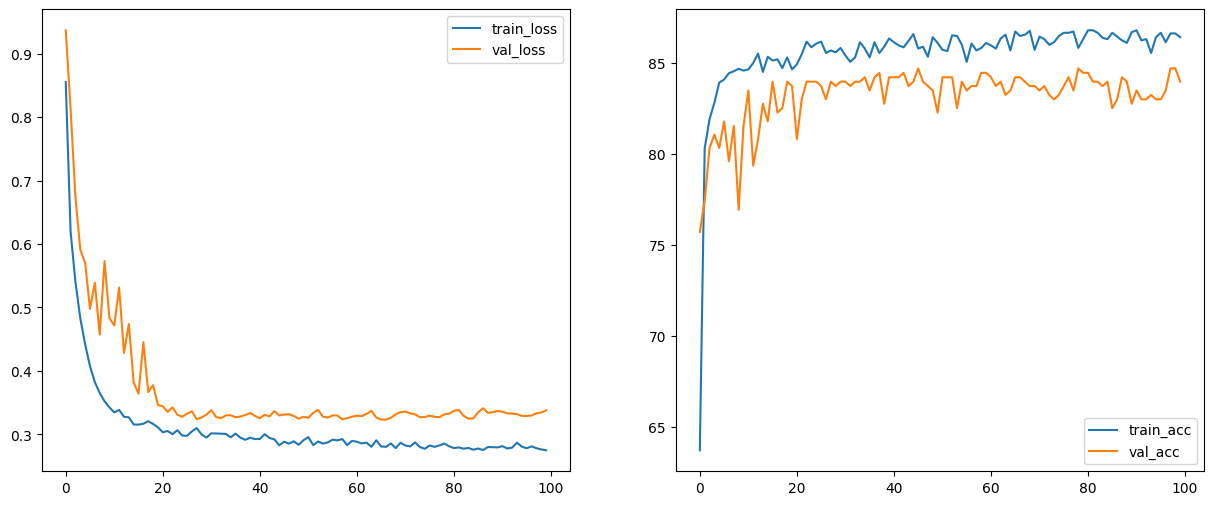

In [2069]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(history[0, :], label="train_loss")
ax1.plot(history[2, :], label="val_loss")
ax1.legend()

ax2.plot(history[1, :], label="train_acc")
ax2.plot(history[3, :], label="val_acc")
ax2.legend()

In [2070]:
model.eval() # Set model to eval mode
true_preds, num_preds = 0., 0.

test_y_hat = []
test_y = []
with torch.no_grad(): # Deactivate gradients for the following code
    for data_inputs, data_labels in test_data_loader:

        # Determine prediction of model on dev set
        data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
        logits = model(data_inputs)
        pred_probabilites = nn.Softmax(dim=1)(logits)
        pred_labels = pred_probabilites.argmax(1)
        test_y_hat.append(pred_labels.to("cpu").numpy())
        test_y.append(data_labels.to("cpu").numpy())

        true_preds += (pred_labels == data_labels).sum()
        num_preds += data_labels.shape[0]

acc = true_preds / num_preds
print(f"Accuracy of the model: {100.0*acc:4.2f}%")

Accuracy of the model: 86.77%


In [2071]:
state_dict = model.state_dict()
torch.save(state_dict, "apartments_86_77_test.tar")